<a href="https://colab.research.google.com/github/JaradAng/tensorflow_training/blob/main/transfer_learning_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring transfer learning and Featrure extraction

transfer learning is leveraging a working models existing architecture and learned patterns for our own problem

two benefits:
1. can leverage an existing nueral network proven to work on similar problems
can levelage working architecture patterns and adapt those on our own.

In [1]:
#downloadin the data into the notebook

import zipfile
#download the data

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

#unip
zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()


--2022-12-11 15:42:51--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 142.250.4.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  23.3MB/s    in 8.2s    

2022-12-11 15:43:00 (19.6 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [2]:
import os

#walk through data
for dirpath, dirnames, filenames in os.walk('10_food_classes_10_percent'):
  print(f'there are {len(dirnames)} directories and {len(filenames)} images in {dirpath}')

there are 2 directories and 0 images in 10_food_classes_10_percent
there are 10 directories and 0 images in 10_food_classes_10_percent/test
there are 0 directories and 250 images in 10_food_classes_10_percent/test/grilled_salmon
there are 0 directories and 250 images in 10_food_classes_10_percent/test/hamburger
there are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_wings
there are 0 directories and 250 images in 10_food_classes_10_percent/test/sushi
there are 0 directories and 250 images in 10_food_classes_10_percent/test/ramen
there are 0 directories and 250 images in 10_food_classes_10_percent/test/ice_cream
there are 0 directories and 250 images in 10_food_classes_10_percent/test/fried_rice
there are 0 directories and 250 images in 10_food_classes_10_percent/test/pizza
there are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_curry
there are 0 directories and 250 images in 10_food_classes_10_percent/test/steak
there are 10 directori

In [14]:
#creating data loadeds
#create train and test data generators and rescale the data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = '/content/10_food_classes_10_percent/train'

test_dir = '/content/10_food_classes_10_percent/test'

train_datagen = ImageDataGenerator(rescale= 1/255.)

test_datagen = ImageDataGenerator(rescale = 1/255.)

train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size = IMAGE_SHAPE,
                                                          batch_size= BATCH_SIZE,
                                                          class_mode= 'categorical')


test_data= test_datagen.flow_from_directory(test_dir,
                                            batch_size=BATCH_SIZE,
                                            class_mode='categorical')


Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


#setting up callbacks (things to run while the model trains)
#call backs are extra functionality added to models to performed during or after training
some of the most popular callbacks are :
* tracking experiments with tensorboard callbacl
* model checkpoint with modelcheckpoitn
* stopping before it overfits with earlystopping

In [27]:
#create a TensorBoard callback and functionize it
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime('%Y%m%d - %H')
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f'saving tensorboard log files to: {log_dir}')
  return tensorboard_callback

Now we'll get the feature vector URLs of two common computer vision architectures, EfficientNetB0 (2019) and ResNetV250 (2016) from TensorFlow Hub using the steps above.

We're getting both of these because we're going to compare them to see which performs better on our data.

🔑 Note: Comparing different model architecture performance on the same data is a very common practice. The simple reason is because you want to know which model performs best for your problem.

Update: As of 14 August 2021, EfficientNet V2 pretrained models are available on TensorFlow Hub. The original code in this notebook uses EfficientNet V1, it has been left unchanged. In my experiments with this dataset, V1 outperforms V2. Best to experiment with your own data and see what suits you.

In [6]:
# Creaeting models using tensorflow hub

# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# # New: EfficientNetB0 feature vector (version 2)
# efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"
     


In [7]:
#import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [12]:
IMAGE_SHAPE = int(IMAGE_SHAPE)

TypeError: ignored

In [17]:
#Making model function to create model from url
def create_model(model_url, num_classes):
  """
  takes a tensorflow hub url and creates a keras sequential model with it 

  Args: model_url(str): tf hub feature extraction url
        num_class (int): number of output neurons in output layer
        should equal number of target classes, default ten

  returns: uncompiled keras sequential modle with model url as feature extractor laay and dense outlayer with num of class as out nuerons
  """

  #download the pretrained model and use it a layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable = False,
                                           name='feature_extractor',
                                           input_shape= IMAGE_SHAPE+(3,)) # freezes the already learned patterns
  
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation='softmax', name='output_layer')
      ])
  
  return model

# creating resnet feature extraction model

In [18]:
resnet_model = create_model(resnet_url,
                            num_classes = train_data_10_percent.num_classes)

In [19]:
#compile resnet model
resnet_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [28]:
history_1 = resnet_model.fit(train_data_10_percent,
                             epochs = 5,
                             steps_per_epoch= len(train_data_10_percent),
                             validation_data= test_data,
                             validation_steps = len(test_data),
                             callbacks = [create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                      experiment_name = 'resnet50V2')])

saving tensorboard log files to: tensorflow_hub/resnet50V2/20221211 - 16
Epoch 1/5
24/24 [==============================] - 19s 789ms/step - loss: 0.3073 - accuracy: 0.9427 - val_loss: 0.6457 - val_accuracy: 0.7928
Epoch 2/5
24/24 [==============================] - 17s 726ms/step - loss: 0.2599 - accuracy: 0.9480 - val_loss: 0.6346 - val_accuracy: 0.7940
Epoch 3/5
24/24 [==============================] - 17s 745ms/step - loss: 0.2210 - accuracy: 0.9733 - val_loss: 0.6161 - val_accuracy: 0.8048
Epoch 4/5
24/24 [==============================] - 17s 721ms/step - loss: 0.1870 - accuracy: 0.9787 - val_loss: 0.6075 - val_accuracy: 0.8012
Epoch 5/5
24/24 [==============================] - 17s 724ms/step - loss: 0.1638 - accuracy: 0.9853 - val_loss: 0.6037 - val_accuracy: 0.8052


In [23]:
import matplotlib.pyplot as plt


In [29]:
#plot validation and training seperately 
def plot_loss_curve(history):
  """
  returns seperate loss curves for training and validation metrics
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  #plot the loss
  plt.plot(epochs, loss, label='training loss')
  plt.plot(epochs, val_loss, label='validation loss')
  plt.title('loss')
  plt.xlabel('epochs')
  plt.legend();

  #plot the accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training accuracy')
  plt.plot(epochs, val_accuracy, label='validation accuracy')
  plt.title('accuracy')
  plt.xlabel('epochs')
  plt.legend();

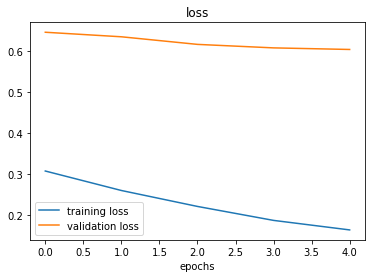

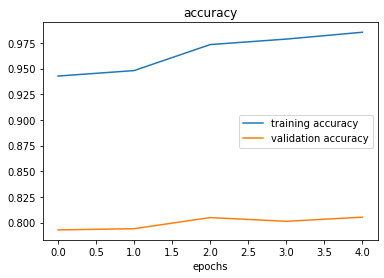

In [30]:
plot_loss_curve(history_1)

In [31]:
efficientnet_model = create_model(efficientnet_url, 
                                  num_classes=train_data_10_percent.num_classes)

In [32]:
#compile the model
efficientnet_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                           optimizer = tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

In [37]:
#fit the model
history_2 = efficientnet_model.fit(train_data_10_percent,
                                   epochs = 5,
                                   steps_per_epoch = len(train_data_10_percent),
                                   validation_data = test_data,
                                   validation_steps = len(test_data),
                                   callbacks = [create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                      experiment_name = 'efficient_net_b0')])

saving tensorboard log files to: tensorflow_hub/efficient_net_b0/20221211 - 16
Epoch 1/5
24/24 [==============================] - 17s 687ms/step - loss: 0.4451 - accuracy: 0.9067 - val_loss: 0.5218 - val_accuracy: 0.8696
Epoch 2/5
24/24 [==============================] - 16s 680ms/step - loss: 0.3909 - accuracy: 0.9240 - val_loss: 0.4932 - val_accuracy: 0.8716
Epoch 3/5
24/24 [==============================] - 16s 684ms/step - loss: 0.3494 - accuracy: 0.9333 - val_loss: 0.4723 - val_accuracy: 0.8768
Epoch 4/5
24/24 [==============================] - 16s 684ms/step - loss: 0.3151 - accuracy: 0.9467 - val_loss: 0.4557 - val_accuracy: 0.8772
Epoch 5/5
24/24 [==============================] - 16s 679ms/step - loss: 0.2835 - accuracy: 0.9560 - val_loss: 0.4429 - val_accuracy: 0.8788


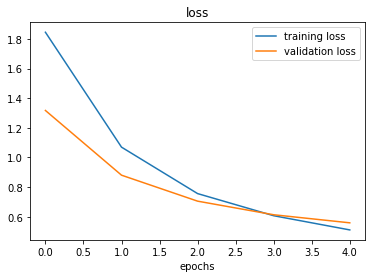

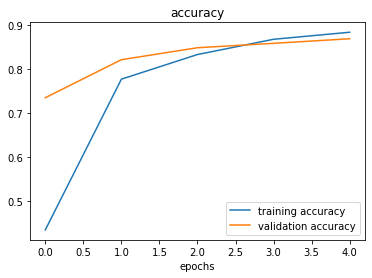

In [36]:
plot_loss_curve(history_2)

### different types of transfer learning

* As-is: using existing model with no changes eg, using all 1000 types
* feature extraction : use prelearned pattern of existing model and adjust output layer for own problem eg, 10%
* fine tuning: use prelearned patterns of existing model and fine tune many or all of the underlayers including new output layers

### Compare models using tensorboard

note: when uploading to tensorboard.dev, experiments are public. so if running private experiments do not upload to the site

In [39]:
#upload to tensorboard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientnetB0 vs Resnet50V2" \
  --description "comparing two different tf hub feature extraction model using 10% of food data" \
  --one_shot


New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/CyIExY9sRSWD54vK2hRRtw/

[2022-12-11T16:47:43] Started scanning logdir.
E1211 16:47:48.941395 140459800934272 uploader.py:1122] Attempted to re-upload existing blob.  Skipping.
[2022-12-11T16:47:51] Total uploaded: 90 scalars, 0 tensors, 2 binary objects (5.6 MB)
Total skipped: 1 binary objects (3.9 MB)
[2022-12-11T16:47:51] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/CyIExY9sRSWD54vK2hRRtw/
